In [1]:
%load_ext autoreload
%autoreload 2

import os, torch, click, numpy as np

import swyft
from utils import *
from plot import *

from tqdm import tqdm



DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'


In [2]:


m = 1
nsub = 3
nsim = 10000
nmbins = 1



lr = 1e-3
factor = 1e-1
patience = 5

system_name = "ngc4414"

In [3]:
# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.Store.load(path=sim_path)
print(f'Store has {len(store)} simulations.')

config = get_config(system_name, str(nsub), str(m))

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

# dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)

Store _M_m1_nsub3_nsim10000 exists!
Loading existing store.
Store has 10049 simulations.
Image has L = 40.


In [4]:
# Load network
mre_name, mre_path = get_mre_path(sim_name, nmbins, lr, factor, patience)
print(f'Loading {mre_name}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmbins, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

Loading UNet_M_m1_nsub3_nsim10000_nmbins1_lr-3.0_fac-1.0_pat5.pt!


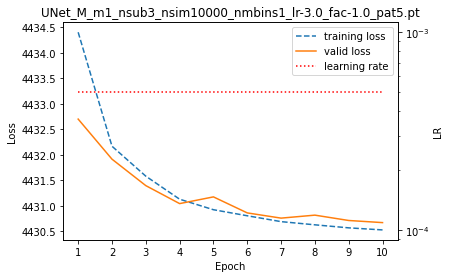

In [5]:
plot_losses(mre, title = mre_name)#, save_name = mre_name)

In [6]:
def get_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmbins+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    
    coord_full = []
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1).to(DEVICE, dtype = torch.float)
        coord_full.append(coord)

    coords = [coord_empty] + coord_full
    return coords, coord_empty, coord_full, m_centers, m_edges 

def get_obs(store, i = -1):
    obs0_i = np.random.randint(0, len(store)) if i == -1 else i
#     print(f'i = {obs0_i}')
    
    obs0 = store[obs0_i][0]
    v0 = store[obs0_i][1]

    obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = tensor(v0).unsqueeze(0).to(DEVICE)
    
    return obs0, v0, obs0_i

coords, coord_empty, coord_full, m_centers, m_edges = get_coords(nmbins, L)

mbins = np.linspace(lows[2], highs[2], nmbins + 1)
title_mbins = [f'mass {mbins[i]} - {mbins[i+1]}' for i in range(nmbins)]
title_halos = [f'{j} {k}' for j in ['no halo', 'halo'] for k in title_mbins ]
titles = [f'{i} {j}' for i in ['target', 'ratio '] for j in title_halos ]


In [7]:
prior = nsub/(L*L)/nmbins
prior0 = 1 - prior
prior1 = prior
priors = np.repeat(np.array([prior0, prior1]), nmbins) 

print(f'prior no halo \t{prior0}\npario halo \t{prior1}')

prior no halo 	0.998125
pario halo 	0.001875


In [8]:
def get_pred(obs0_i = -1):
    
    # Get observation and targets
    obs0, v0, obs0_i = get_obs(store, obs0_i)
    targets = mre.network.parameter_transform(v0).squeeze()
    target = targets[nmbins:].numpy()

    # Get logratios
    logratios = np.zeros((nmbins*2, L, L))
    logratios[:nmbins] = mre.network(obs0, coord_empty).view(nmbins*2, L, L)[:nmbins]
    logratios[nmbins:] = torch.stack([
        mre.network(obs0, coord).view(nmbins*2, L, L)[i+nmbins] for i, coord in enumerate(coord_full)
    ])
        
    # Posterior 
    posts = np.exp(logratios) * (priors)[:, np.newaxis, np.newaxis]
    posts_sum = np.sum(posts.reshape(2, nmbins, L, L).transpose([1,0,2,3]), axis = 1)
    posts_sum = np.tile(posts_sum, (2,1,1))
    posts_norm = posts / posts_sum
    
    # Target coordinates
    y, x, m = v0.view(-1, 3).T.numpy()
    m_i = np.where(targets[nmbins:] == 1)[0]
    target_coords = np.array((m_i, x, y)).T
    target_coords_alt = np.array((m_i, y,x)).T
    
    scatter = np.array([np.array(np.where(target == 1))[i] for i in [2, 1, 0]])
    scatter_alt= np.array([np.array(np.where(target == 1))[i] for i in [1,2, 0]])
    
    return posts_norm[nmbins:], target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts, target, obs0_i



## Final results

In [9]:
def find_nrows(l):
    if l > 1:
        a = np.array([(i, l/i, i+l/i) for i in range(1, l) if (l/i).is_integer()])
        i_min = np.argmin(a[:, -1], axis = 0)
        return int(a[i_min].min()) 
    else:
        return 1

3.033204515618078


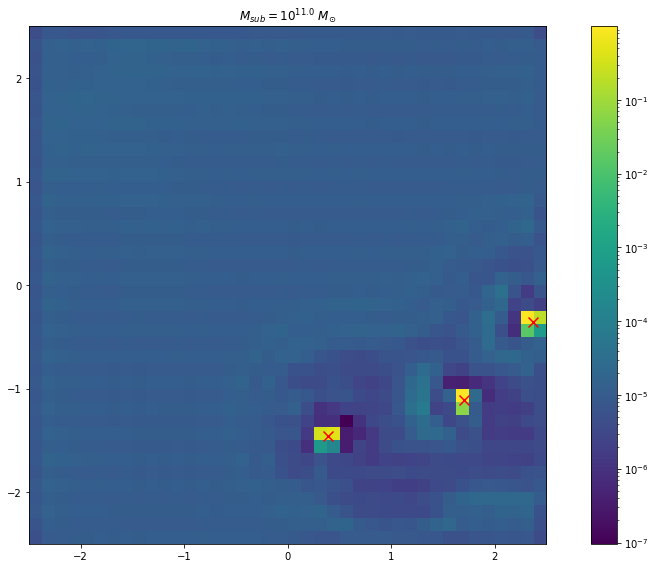

In [11]:
for _ in range(1):
#   30627
    post, target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts_all, target, obs0_i = get_pred(-1)
    
    print(np.sum(post))
    
    nrows = find_nrows(len(post))
    titles = [rf'$M_{{sub}} = 10^{ {m} }\ M_{{\odot}}$' for m in np.log10(m_centers.numpy())]

    log = True
#     plt_imshow(post, nrows, target_coords = target_coords, cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)
    plt_imshow(post, nrows, target_coords = target_coords, cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)


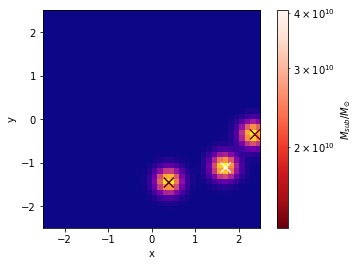

In [12]:
fig, ax = plt.subplots()

ax.imshow(obs0['image'].squeeze(), cmap = 'plasma', **imkwargs)
im = ax.scatter(y, x, marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())

cbar = plt.colorbar(im, ax = ax)
cbar.ax.set_ylabel(r'$M_{sub}/M_{\odot}$')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

# RMSD

In [13]:
n_obs = 10_000
posts = np.zeros((n_obs, *post.shape))
targets = np.zeros((n_obs, *target.shape))
inds = np.zeros((n_obs))
obs0s = np.zeros((n_obs, L, L))

In [14]:
OVERWRITE = False
preds_name = f'../data/preds/{mre_name[:-3]}_nobs{n_obs}_PREDS.npy'

if OVERWRITE is True or not os.path.exists(preds_name):
    for i in tqdm(range(n_obs)): # loop over number of observations we will take into account
        post, target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts_all, target, obs0_i = get_pred()
        posts[i], targets[i] = post, target
        inds[i] = obs0_i
        obs0s[i] = obs0['image'].squeeze().numpy()

    with open(preds_name, 'wb') as f:
        np.save(f, posts)
        np.save(f, targets)
        np.save(f, inds)
        np.save(f, obs0s)

else:
    with open(preds_name, 'rb') as f:
        posts   = np.load(f)
        targets = np.load(f)
        inds    = np.load(f)
        obs0s   = np.load(f)

 22%|██▏       | 2243/10000 [01:10<04:47, 26.98it/s]/scratch/ipykernel_10189/889038086.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  target_coords = np.array((m_i, x, y)).T
/scratch/ipykernel_10189/889038086.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  target_coords_alt = np.array((m_i, y,x)).T
100%|██████████| 10000/10000 [05:01<00:00, 33.18it/s]


In [15]:
errs = posts - targets
merr = np.sum(errs,    axis = 0) / n_obs
rmsd = np.sqrt( np.sum((posts - target)**2, axis = 0) / n_obs)

while rmsd[np.unravel_index(rmsd.argmax(), rmsd.shape)] > 0.99:
    max_index = np.unravel_index(rmsd.argmax(), rmsd.shape)
    print(rmsd[max_index], max_index)
    rmsd[max_index] = 0

0.998839294755763 (0, 36, 31)
0.9985971270656251 (0, 19, 38)
0.9985411054895093 (0, 23, 32)


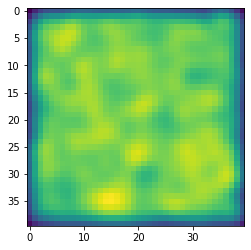

In [16]:
plt.imshow(np.mean(obs0s, axis = (0)))

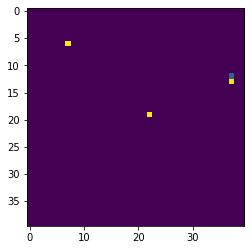

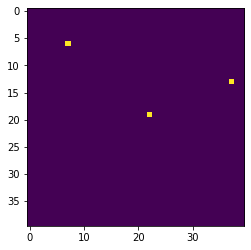

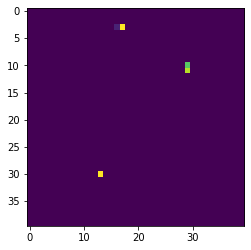

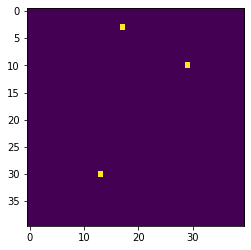

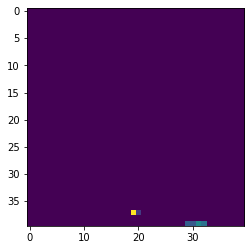

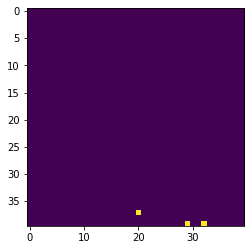

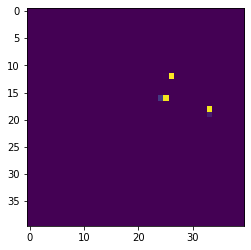

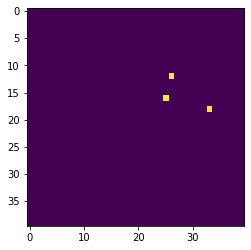

In [17]:
for i in range(4):
    plt_imshow(posts[i], y = 4)
    plt_imshow(targets[i], y = 4)

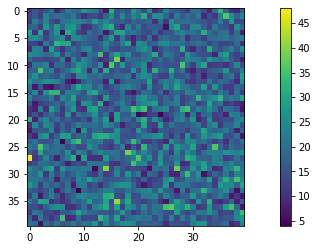

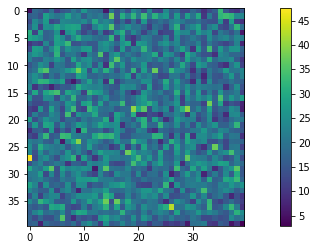

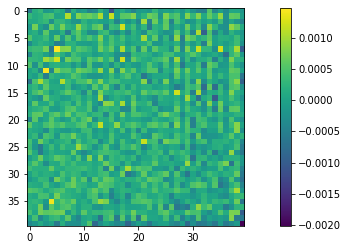

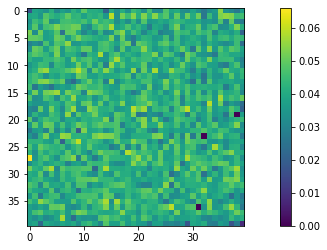

In [21]:
targets_sum = np.sum(targets, axis = 0)
posts_sum   = np.sum(posts,   axis = 0)

plt_imshow(targets_sum, cbar = True, y = 4)
plt_imshow(posts_sum, cbar = True, y = 4)

plt_imshow(merr, cbar = True, y = 4)
plt_imshow(rmsd, cbar = True, y = 4)